# <center> Honolulu Climate Analysis </center>
![BeautifulBeach](https://ohmygosh2009.files.wordpress.com/2011/06/tropical-for-vacation-climate-blog.jpg)

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

from pprint import pprint #pretty print

degree_sign= u'\N{DEGREE SIGN}' #degree symbol to be used for printing;

In [2]:
# ––––––––––––––––––––––––––––––––––––- * CHECK PLOT DIMENSIONS * ––––––––––––––––––––––––––––––––––––-
plt_dimensions = plt.rcParams["figure.figsize"] 
print(f"Plot Dimensions ⟶ (width = {plt_dimensions[0]}) x (height = {plt_dimensions[1]})")

Plot Dimensions ⟶ (width = 6.0) x (height = 4.0)


In [3]:
# ––––––––––––––––––––––––––––––––––––- * SETTING NEW PLOT DIMENSIONS * ––––––––––––––––––––––––––––––––––––-
plt_dimensions[0] = 16.0                          #set width
plt_dimensions[1] = 9.0                           #set height
plt.rcParams["figure.figsize"] = plt_dimensions #
print(f"Plot Dimensions ⟶ (width = {plt_dimensions[0]}) x (height = {plt_dimensions[1]})")

Plot Dimensions ⟶ (width = 16.0) x (height = 9.0)


## <center> Reflect Tables into SQLAlchemy ORM </center>

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Create enginge connection to sqlite DB, automap into local model, reflect tables, & view classes 
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base() # reflect an existing database into a new model
Base.prepare(engine, reflect=True) # reflect the tables
Base.classes.keys() # We can view all of the classes that automap found

['measurement', 'station']

In [6]:
# References to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

## <center> Exploratory Climate Analysis </center>

In [8]:
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).\
            first()
first_date = session.query(Measurement.date).\
            order_by(Measurement.date.asc()).\
            first()

print(f'The earliest date with available data is {first_date} & the latest date is {last_date}')

The earliest date with available data is ('2010-01-01',) & the latest date is ('2017-08-23',)


/Users/Omar/anaconda3/envs/pythonomy/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Text(0, 0.5, 'Inches')

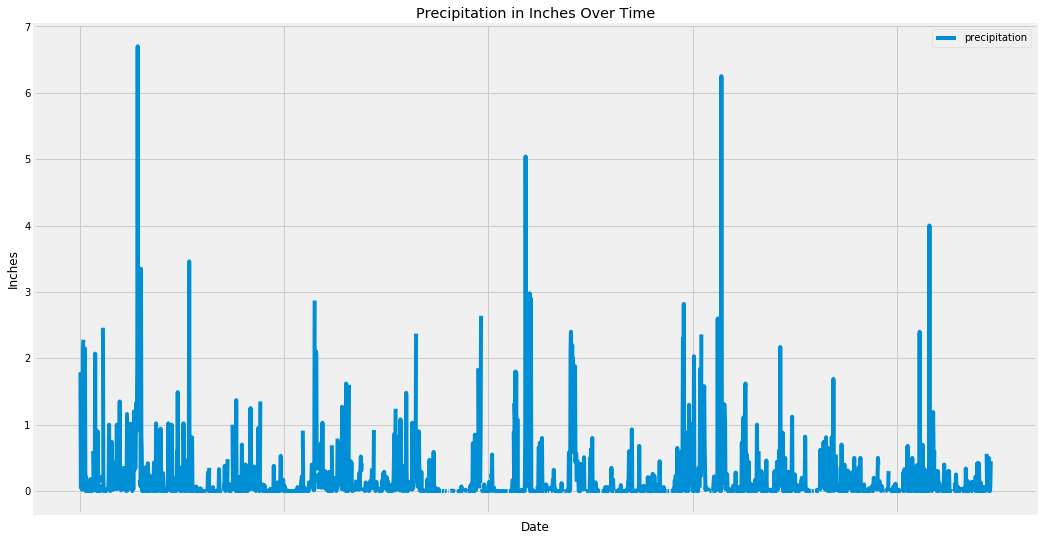

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
          filter(Measurement.date >= prev_year).\
          all()

# Save the query results as a Pandas DataFrame and set the index to the date column
final_year_df = pd.DataFrame(results, columns=['date', 'precipitation'])
final_year_df.set_index(final_year_df['date'], inplace=True)

# Sort the dataframe by date
final_year_df = final_year_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
final_year_df.plot(x_compat=True)
plt.title("Precipitation in Inches Over Time")
plt.xlabel("Date")
plt.ylabel("Inches")

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
final_year_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## <center> Station Analysis </center>

In [11]:
# Design a query to show how many stations are available in this dataset?
#session.query(Station).count()
number_of_locations = session.query(Station).\
                      group_by(Station.station).\
                      count()
print(f'There are {number_of_locations} different stations')

There are 9 different stations


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Station.station, func.count(Measurement.station).label('actives')).\
                  filter(Station.station == Measurement.station).\
                  group_by(Station.station).\
                  order_by(func.count(Measurement.station).desc()).\
                  all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
first_station = active_stations[0].station
print(f'The most active station is {first_station}')

The most active station is USC00519281


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_sel = [func.min(Measurement.tobs), 
                          func.max(Measurement.tobs),
                          func.avg(Measurement.tobs)]

most_active_station_query = session.query(*most_active_station_sel).\
                            filter(Measurement.station == first_station).\
                            all()
most_active_station_results = list(np.ravel(most_active_station_query)) #ravel will flatten 2x2 to 1 dimension; 
most_active_station_results

print(f'Most Active Station: {first_station}')
print('–'*30)
print(f'Temperature Statistics:\n\
 Minimum: {most_active_station_query[0][0]}{degree_sign}F,\n\
 Maximum: {round(most_active_station_query[0][2], 1)}{degree_sign}F,\n\
 Average: {most_active_station_query[0][1]}{degree_sign}F.')

print('–'*30)

Most Active Station: USC00519281
––––––––––––––––––––––––––––––
Temperature Statistics:
 Minimum: 54.0°F,
 Maximum: 71.7°F,
 Average: 85.0°F.
––––––––––––––––––––––––––––––


In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.station, Measurement.tobs).\
          filter(Measurement.date >= prev_year).\
          filter(Measurement.station == first_station).\
          all()

# Save the query results as a Pandas DataFrame and set the index to the date column
frequency_df = pd.DataFrame(results, columns=['Station', 'Total Observations'])
# grouped_frequency_df = frequency_df.groupby(['Total Observations'])['Total Observations'].agg({'Frequency':'count'})
# grouped_frequency_df.plot.hist(by=grouped_frequency_df.Frequency, bins=10)
#grouped_frequency_df
frequency_df.head()

,Station,Total Observations
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


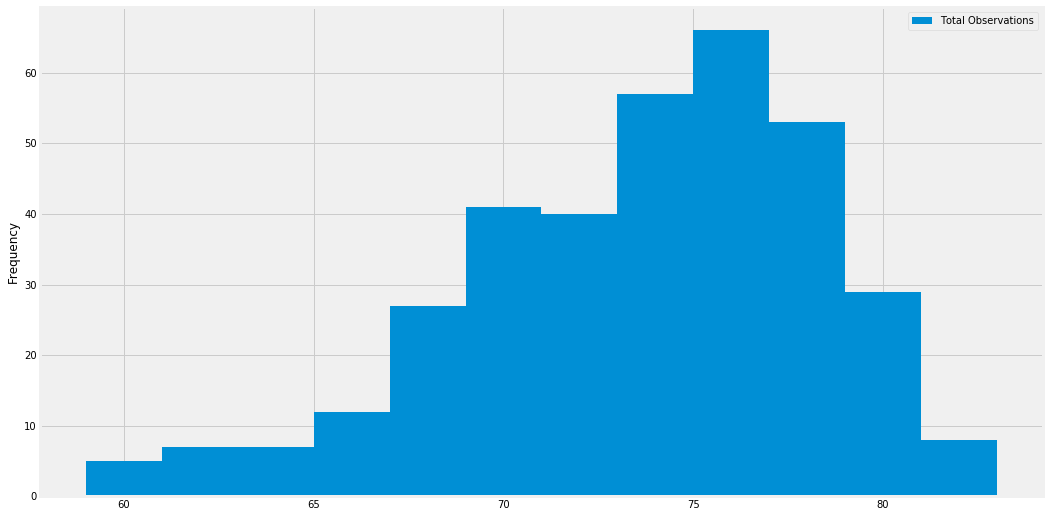

In [16]:
# frequency_df = pd.DataFrame(results, columns=['Total Observations'])
# grouped_frequency_df = frequency_df.groupby(['Total Observations'])['Total Observations'].agg({'Frequency':'count'})
frequency_df.plot.hist(bins=12)
#grouped_frequency_df

## <center> Temperature Analysis </center>

In [17]:
# The `calc_temps` functions accepts start & end dates in the format '%Y-%m-%d' & returns statistics on date range
def calc_temps(start_date, end_date):
    """
    Arguments:    start_date (string): A date string in the format %Y-%m-%d
                  end_date (string): A date string in the format %Y-%m-%d
    Returns:      TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), 
                         func.avg(Measurement.tobs), 
                         func.max(Measurement.tobs)).\
                         filter(Measurement.date >= start_date).\
                         filter(Measurement.date <= end_date).\
                         all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


## <center> Expected Temperature Calculation </center>
#### <center> (Based on previous year's data) </center>

In [19]:
# * Use the `calc_temps` function to get the min, avg, & max temps for trip duration using previous year data
# –––––––––––––––––––––––––––––––––––––– User Input –––––––––––––––––––––––––––––––––––––– #

print("Let's determine the temperatures that can be expected during the trip to Hawaii\n\n")
print('–'*30)
month = int(input("What Month? " ))
day = int(input("What day? " ))
year = int(input("What year? "))
duration = int(input("How many days will you stay? "))
print('–'*30)

# –––––––––––––––––––––––––––––––––––––– Calculations –––––––––––––––––––––––––––––––––––––– #

trip_start_date = str(year) + '–' + str(month) + '-' + str(day) 
pretty_trip_start_date = str(month) + '-' + str(day) + '-' + str(year)

previous_year_trip_start = dt.date(year, month, day) - dt.timedelta(days=365) #previous year initial date
previous_year_trip_start_string = previous_year_trip_start.strftime('%Y-%m-%d') #needed for 'calc' function

trip_end_date = dt.date(year, month, day) + dt.timedelta(days=duration) # start date + duration
trip_end_date_string = trip_end_date.strftime('%m-%d-%Y') #for printing


previous_year_trip_end = trip_end_date - dt.timedelta(days=365) #previous year final date
previous_year_trip_end_string = previous_year_trip_end.strftime('%Y-%m-%d') #needed for 'calc' function;

expected_temps = calc_temps(previous_year_trip_start_string, previous_year_trip_end_string)

# –––––––––––––––––––––––––––––––––––––– Printing Results –––––––––––––––––––––––––––––––––––––– #

min_expected_temp = expected_temps[0][0]
avg_expected_temp = round(expected_temps[0][1], 2)
max_expected_temp = expected_temps[0][2]

print(f'Expected Trip Duration: {pretty_trip_start_date} through {trip_end_date_string}')
print('–'*30)
print(f'Expected Temperatures:\n\
 Minimum: {min_expected_temp}{degree_sign}F,\n\
 Maximum: {max_expected_temp}{degree_sign}F,\n\
 Average: {avg_expected_temp}{degree_sign}F.')
print('–'*30)

Let's determine the temperatures that can be expected during the trip to Hawaii


––––––––––––––––––––––––––––––
What Month? 02
What day? 14
What year? 2018
How many days will you stay? 14
––––––––––––––––––––––––––––––
Expected Trip Duration: 2-14-2018 through 02-28-2018
––––––––––––––––––––––––––––––
Expected Temperatures:
 Minimum: 61.0°F,
 Maximum: 79.0°F,
 Average: 70.87°F.
––––––––––––––––––––––––––––––


In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temps_df = pd.DataFrame.from_records(expected_temps).rename(columns={0:'Minimum', 1:'Average', 2:'Maximum'})
trip_temps_df

,Minimum,Average,Maximum
0,61.0,70.869565,79.0


Text(0.5, 1.0, 'Trip Average Temperature')

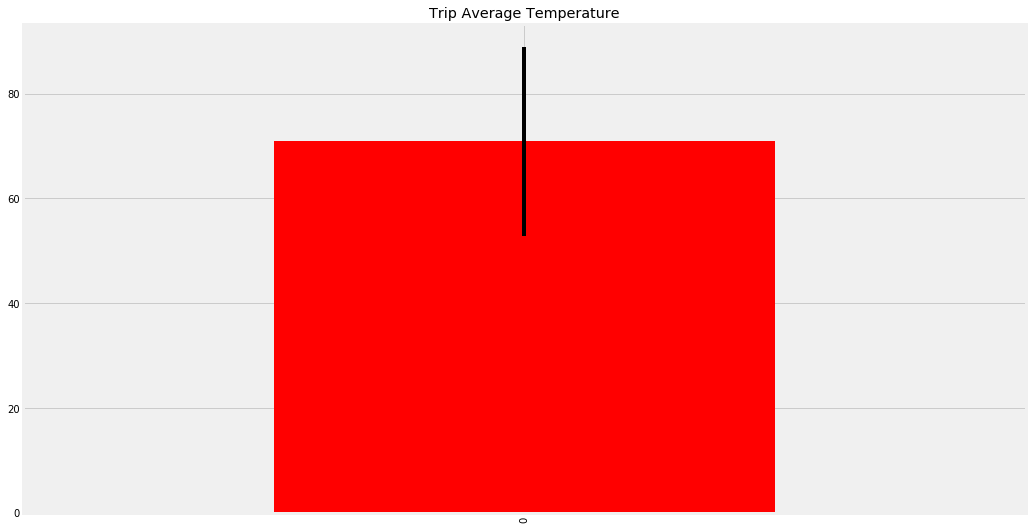

In [21]:
mean = trip_temps_df.Average
y_error_bar = trip_temps_df.Maximum - trip_temps_df.Minimum

mean.plot.bar(yerr=y_error_bar, color='red')
plt.title('Trip Average Temperature')

In [27]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_query = [Station.name, 
                 Station.station, 
                 Station.elevation, 
                 Station.longitude, 
                 Station.latitude, 
                 func.sum(Measurement.prcp).label('total_rainfall')]

station_results = session.query(*station_query).\
                  filter(Measurement.station == Station.station).\
                  filter(Measurement.date >= previous_year_trip_start).\
                  filter(Measurement.date <= previous_year_trip_end).\
                  group_by(Station.name).\
                  order_by('total_rainfall').\
                  all()
pprint(station_results)

[('PEARL CITY, HI US', 'USC00517948', 11.9, -157.9751, 21.3934, 0.17),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 3.0, -157.8168, 21.2716, 0.23),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  7.0,
  -157.8374,
  21.5213,
  0.83),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  'USC00519523',
  19.5,
  -157.71139,
  21.33556,
  0.87),
 ('KANEOHE 838.1, HI US', 'USC00513117', 14.6, -157.8015, 21.4234, 1.02),
 ('WAIHEE 837.5, HI US',
  'USC00519281',
  32.9,
  -157.84888999999998,
  21.45167,
  1.06),
 ('MANOA LYON ARBO 785.2, HI US',
  'USC00516128',
  152.4,
  -157.8025,
  21.3331,
  1.4)]


### Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """
    Args:    date (str): A date string in the format '%m-%d'
    Returns: A list of tuples containing the daily normals, tmin, tavg, and tmax"""
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
